<a href="https://colab.research.google.com/github/claudeshyaka/Real-Time_Machine_Learning/blob/main/ModernRNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Claude Shyaka
## ID# 801362243
## Real-Time Machine Learning -- ModernRNNs

In [1]:
# !pip install pip==21.3.1
!pip install -q d2l==1.0.0a1.post0
# !pip install -q d2l

%matplotlib inline
import time
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.nn import functional as F
from d2l import torch as d2l
import collections
import random
import re

d2l.use_svg_display()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.8 MB/s eta 0:00:00


## Reading Dataset

In [2]:

class TimeMachine(d2l.DataModule):
  """The Time Machine dataset."""
  def _download(self):
    fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                            '090b5e7e70c295757f55df93cb0a180b9691891a')
    with open(fname) as f:
        return f.read()

data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [3]:
@d2l.add_to_class(TimeMachine)
def _preprocess(self, text):
  return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

## Tokenization

In [4]:
@d2l.add_to_class(TimeMachine)
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

## Vocabulary

In [5]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [6]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [7]:
@d2l.add_to_class(TimeMachine)
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

In [8]:
@d2l.add_to_class(d2l.TimeMachine)
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(
        self.num_train, self.num_train + self.num_val)
    return self.get_tensorloader([self.X, self.Y], train, idx)

In [9]:
data = d2l.TimeMachine(batch_size=2, num_steps=10)
for X, Y in data.train_dataloader():
    print('X:', X, '\nY:', Y)
    break

X: tensor([[ 0,  9,  6,  0, 21, 16, 16, 12,  0, 16],
        [ 0, 12, 15, 16, 24,  0, 16,  7,  0,  4]]) 
Y: tensor([[ 9,  6,  0, 21, 16, 16, 12,  0, 16, 15],
        [12, 15, 16, 24,  0, 16,  7,  0,  4, 16]])


## Problem 1

### Gated Recurrent Unit

#### GRU Base-Line

In [10]:
class GRU(d2l.RNN):
  def __init__(self, num_inputs, num_hiddens):
    d2l.Module.__init__(self)
    self.save_hyperparameters()
    self.rnn = nn.GRU(num_inputs, num_hiddens)

60.75 sec


'it has inter the the the t'

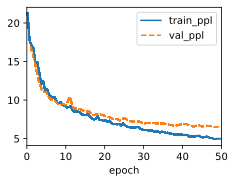

In [11]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
modelGRU = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)

tic = time.time()
trainer.fit(modelGRU, data)
print(f'{time.time() - tic:.2f} sec')
modelGRU.predict('it has', 20, data.vocab, d2l.try_gpu())

#### GRU modified with 64 hidden layers

52.03 sec


'it has go back and said th'

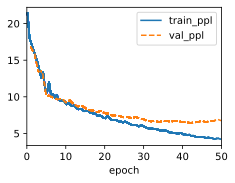

In [12]:
gru64Hidden = GRU(num_inputs=len(data.vocab), num_hiddens=64)
modelGRU64 = d2l.RNNLM(gru64Hidden, vocab_size=len(data.vocab), lr=4)

tic = time.time()
trainer.fit(modelGRU64, data)
print(f'{time.time() - tic:.2f} sec')
modelGRU64.predict('it has', 20, data.vocab, d2l.try_gpu())

#### Complexity and model size

In [13]:
# complexity and model size
!pip install -q ptflops

  Preparing metadata (setup.py) ... done


In [14]:
from ptflops import get_model_complexity_info

with torch.cuda.device(0):  
  nets = [gru, gru64Hidden]
  for net in nets:
    macs, params = get_model_complexity_info(net, (len(data.vocab), 28), 
                      as_strings=True, print_per_layer_stat=False, 
                      verbose=False)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    print('---------------------')

Computational complexity:       172.93 KMac
Number of parameters:           5.95 k  
---------------------
Computational complexity:       517.89 KMac
Number of parameters:           18.05 k 
---------------------


### Long Short-Term Memory

#### LSTM baseline

52.42 sec


'it has and the the the the'

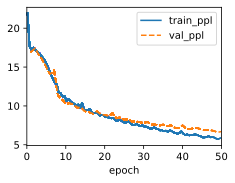

In [15]:
class LSTM(d2l.RNN):
  def __init__(self, num_inputs, num_hiddens):
    d2l.Module.__init__(self)
    self.save_hyperparameters()
    self.rnn = nn.LSTM(num_inputs, num_hiddens)

  def forward(self, inputs, H_C=None):
    return self.rnn(inputs, H_C)

lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
modellstm = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)

tic = time.time()
trainer.fit(modellstm, data)
print(f'{time.time() - tic:.2f} sec')
modellstm.predict('it has', 20, data.vocab, d2l.try_gpu())

#### LSTM modified with 64 hidden layers

52.50 sec


'it has it and said the pro'

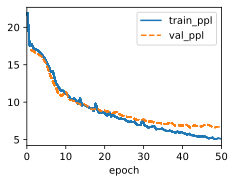

In [16]:
lstm64 = LSTM(num_inputs=len(data.vocab), num_hiddens=64)
modellstm64 = d2l.RNNLM(lstm64, vocab_size=len(data.vocab), lr=4)

tic = time.time()
trainer.fit(modellstm64, data)
print(f'{time.time() - tic:.2f} sec')
modellstm64.predict('it has', 20, data.vocab, d2l.try_gpu())

#### Complexity and model size

In [17]:
with torch.cuda.device(0):  
  nets = [lstm, lstm64]
  for net in nets:
    macs, params = get_model_complexity_info(net, (len(data.vocab), 28), 
                      as_strings=True, print_per_layer_stat=False, 
                      verbose=False)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    print('---------------------')

Computational complexity:       231.17 KMac
Number of parameters:           7.94 k  
---------------------
Computational complexity:       691.71 KMac
Number of parameters:           24.06 k 
---------------------


## Problem 2

### Deep GRU

#### Deep GRU baseline

In [18]:
class GRU(d2l.RNN):
  """The multi-layer GRU model."""
  def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
    d2l.Module.__init__(self)
    self.save_hyperparameters()
    self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers,
                      dropout=dropout)


161.30 sec


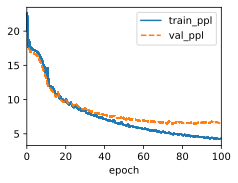

In [19]:
gruDeep = GRU(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
modelgruDeep = d2l.RNNLM(gruDeep, vocab_size=len(data.vocab), lr=2)

trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)

tic = time.time()
trainer.fit(modelgruDeep, data)
print(f'{time.time() - tic:.2f} sec')

In [20]:
print(modelgruDeep.predict('it has', 20, data.vocab, d2l.try_gpu()))
print(modelgruDeep.predict('I am', 20, data.vocab, d2l.try_gpu()))

it has is and the time the
<unk> amon the time the time


#### Deep GRU modified with 3 states and 64 hidden layers

163.98 sec


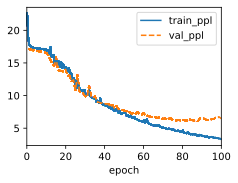

In [21]:
gruDeep64 = GRU(num_inputs=len(data.vocab), num_hiddens=64, num_layers=3)
modelgruDeep64 = d2l.RNNLM(gruDeep64, vocab_size=len(data.vocab), lr=2)

tic = time.time()
trainer.fit(modelgruDeep64, data)
print(f'{time.time() - tic:.2f} sec')

In [22]:
print(modelgruDeep64.predict('it has', 20, data.vocab, d2l.try_gpu()))
print(modelgruDeep64.predict('I am', 20, data.vocab, d2l.try_gpu()))

it has a mathematical man 
<unk> amon a mathematical ma


#### Complexity and model size

In [23]:
with torch.cuda.device(0):  
  nets = [gruDeep, gruDeep64]
  for net in nets:
    macs, params = get_model_complexity_info(net, (len(data.vocab), 28), 
                      as_strings=True, print_per_layer_stat=False, 
                      verbose=False)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    print('---------------------')

Computational complexity:       356.61 KMac
Number of parameters:           12.29 k 
---------------------
Computational complexity:       1.94 MMac
Number of parameters:           67.97 k 
---------------------


### Deep LSTM

#### Deep LSTM baseline

In [24]:
class LSTM(d2l.RNN):
  """The multi-layer LSTM model."""
  def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
    d2l.Module.__init__(self)
    self.save_hyperparameters()
    self.rnn = nn.LSTM(num_inputs, num_hiddens, num_layers,
                      dropout=dropout)

161.97 sec


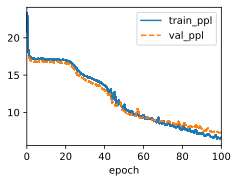

In [25]:
lstmDeep = LSTM(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
modellstmDeep = d2l.RNNLM(lstmDeep, vocab_size=len(data.vocab), lr=2)

tic = time.time()
trainer.fit(modellstmDeep, data)
print(f'{time.time() - tic:.2f} sec')

In [26]:
# model output examples
print(modellstmDeep.predict('it has', 20, data.vocab, d2l.try_gpu()))
print(modellstmDeep.predict('we are there', 20, data.vocab, d2l.try_gpu()))

it has sont and the the th
we are there the the the the the


#### Deep LSTM modified with 4 state and 64 hidden layers

164.54 sec


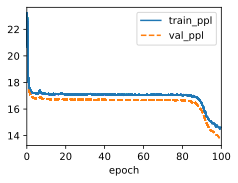

In [30]:
lstmDeep64 = LSTM(num_inputs=len(data.vocab), num_hiddens=64, num_layers=3)
modellstmDeep64 = d2l.RNNLM(lstmDeep64, vocab_size=len(data.vocab), lr=2)

tic = time.time()
trainer.fit(modellstmDeep64, data)
print(f'{time.time() - tic:.2f} sec')

In [31]:
# model output examples
print(modellstmDeep64.predict('it has', 20, data.vocab, d2l.try_gpu()))
print(modellstmDeep64.predict('we are there', 20, data.vocab, d2l.try_gpu()))

it has ta a a a a a a a a 
we are there ta a a a a a a a a 


#### Complexity and model size

In [32]:
with torch.cuda.device(0):  
  nets = [lstmDeep, lstmDeep64]
  for net in nets:
    macs, params = get_model_complexity_info(net, (len(data.vocab), 28), 
                      as_strings=True, print_per_layer_stat=False, 
                      verbose=False)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    print('---------------------')

Computational complexity:       476.67 KMac
Number of parameters:           16.38 k 
---------------------
Computational complexity:       2.59 MMac
Number of parameters:           90.62 k 
---------------------
